In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# YKD LAKE Model Benchmarking
This script is used to compare one or multiple LAKE model runs with obsereved water temperatures and concentrations of CO2 and CH4. The data preparation relies on LAKE model output in the second format option (output files ending in '1f2.dat').

In [50]:
def parse_layer_file(filepath):
    '''
    Read in LAKE model layers file 'layers 1 1.dat'

    Args:
    filepath (string): full filepath to layers file

    Output:
    layers (pd.DataFrame)
    '''
    layers=pd.read_csv(filepath, delimiter=r"\s+", skiprows=19, index_col=None, header=None)
    layers.columns=['year', 'month', 'day', 'hour', 'integration_time', 'water layer thickness, m', 
                           'W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                           'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m',
                           'ice layer thickness,   m', 'snow layer thickness,  m', 'bottom ice thickness,  m', 'reservoir volume,  m**3', 'volume deficit (accumulated),  m**3']
    layers['Date'] = pd.to_datetime({'Year': layers['year'], 'Month': layers['month'], 'Day':layers['day']})
    layers['mean_mixed_layer_thickness'] = layers[['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m']].mean(axis=1)
    layers['mean_lower_layer_thickness'] = layers[['W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m']].mean(axis=1)
    layers = layers.drop(columns = ['W mixed layer thickness, m', 'E mixed layer thickness, m', 'S mixed layer thickness, m', 'N mixed layer thickness, m',
                                    'W lower layer thickness, m', 'E lower layer thickness, m', 'S lower layer thickness, m', 'N lower layer thickness, m'])
    layers['run_name'] = filepath.split('/')[-2]

    return layers

def parse_univariate_file(filepath, variable_name):
    '''
    Read in LAKE model univariate timeseries file in second format '{variable} 1 1f2.dat'. Outputs variable time series to pandas DataFrame.
    Expects first five columns are 'year', 'month', 'day', 'hour', and 'integration_time'
    --------------------------------------------------------------------------------------
    Tested for
    water temperature: filename = 'water_temp  1  1f2.dat'
    co2 conventation: filename = 'co2_water  1  1f2.dat'
    ch4 concentration: filename = 'methane_water  1  1f2.dat'
    o2 concentration: filename = 'oxygen_water  1  1f2.dat'
    doc concentration: filename = 'DOC  1  1f2.dat'
    --------------------------------------------------------------------------------------

    Args:
    filepath (string): full filepath to time series file
    vaeriable_name (string): name for time series variable column

    Output:
    layers (pd.DataFrame)
    '''
    
    file=pd.read_csv(filepath, delimiter=r"\s+", skiprows=7, index_col=None, header=None)
    file.columns=['year', 'month', 'day', 'hour', 'integration_time', 'depth', variable_name]
    file['Date'] = pd.to_datetime({'Year': file['year'], 'Month': file['month'], 'Day':file['day']})

    return file

def ppm_to_molarity(ppm, gas, T, P=1, Vh=60, Vb=160, temp_input = 'C'):
    # for headspace measurements
    # T in kelvin
    # assuming P = 1 atm
    # MW in g/mole
    
    if temp_input == 'C':
        T = T+273.15
    constants = {'ch4': {'H': 39769, 'MW': 16.04},
                 'o2': {'H': 43414, 'MW': 32},
                 'R': 1.98719}
    
    constants['ch4']['H'] = 1/(np.exp((-365.183 + 18106.7 / T + 49.7554 * np.log(T) + -0.00028503 * T) / constants['R']))
    constants['o2']['H'] = 1/(np.exp((-286.942 + 15450.6 / T + 36.5593 * np.log(T) + 0.01876620 * T) / constants['R']))
    
    Cg = (ppm*1e-6)
    pg = Cg * P #partial pressure of gas at atmospheric pressure (atm)
    CAH = 55.5 * (pg/constants[gas]['H']) * constants[gas]['MW'] + ((Vh/(Vb-Vh)) * Cg * (constants[gas]['MW']/22.4) * (273 / T)) #gas concentration in aqueous phase (g/L)

    return (CAH / constants[gas]['MW']) * 1e6 # mol gas / L water
    
def Vant_Hoff(T):
    #calculates Henry's law coefficient for CO2 at given temperature
    KHstar = 29
    kT_CO2 = 2400
    T_star = 298.15
    KH = KHstar * np.exp(kT_CO2*((1 / T) - (1 / T_star)))

    return KH
    
def ppm_to_molarity_co2(co2_ppm, T, sensor_depth=1, mean_air_pres = 100986, temp_input = 'C'):
    #for co2 sensor measurements
    p_hydrostatic = 1000 * 9.8 * sensor_depth #Pa
    co2_ppm_corr = co2_ppm * (mean_air_pres/(mean_air_pres+p_hydrostatic))

    pCO2 = co2_ppm_corr * (mean_air_pres+p_hydrostatic) * 1e-6
    
    if temp_input=='C':
        T = T+273.15
        
    KH = Vant_Hoff(T) * 101325

    MCO2 = (pCO2 / KH) #mol CO2 / L solution
    
    return MCO2 * 1e6 #umol/L

In [51]:
datafile_names = {'layers': 'layers  1  1.dat',
                  'water_temp': 'water_temp  1  1f2.dat',
                  'co2_water': 'co2_water  1  1f2.dat',
                  'ch4_water': 'methane_water  1  1f2.dat',
                  'o2_water': 'oxygen_water  1  1f2.dat',
                  'doc_water': 'DOC  1  1f2.dat'}

In [52]:
print('Methane concentration, $\mu g/l$')

Methane concentration, $\mu g/l$


In [53]:
!pwd

/home/amullen/Lake-Model-Data/model_output


In [54]:
#paths_to_burned_LAKE_output = ['/home/amullen/LAKE/results/YKD-burned_bgc-default/time_series', '/home/amullen/LAKE/results/YKD-burned_bgc-lift/time_series']
#paths_to_burned_LAKE_output = ['/home/amullen/LAKE/results/YKD-burned-8y/time_series', '/home/amullen/LAKE/results/YKD-burned/time_series']
paths_to_burned_LAKE_output = ['/home/amullen/Lake-Model-Data/multi_processing/outputs/LAKE{}/results/YKD{}/time_series'.format(i,i) for i in range(0,100)]
paths_to_burned_LAKE_output = paths_to_burned_LAKE_output[:4]+paths_to_burned_LAKE_output[5:]
#paths_to_unburned_LAKE_output = ['/home/amullen/LAKE/results/YKD-burned_bgc-default/time_series', '/home/amullen/LAKE/results/YKD-burned_bgc-lift/time_series']
#paths_to_unburned_LAKE_output = ['/home/amullen/LAKE/results/YKD-burned-8y/time_series', '/home/amullen/LAKE/results/YKD-burned/time_series']
paths_to_unburned_LAKE_output = ['/home/amullen/Lake-Model-Data/multi_processing/outputs/LAKE{}/results/YKD{}/time_series'.format(i,i) for i in range(0,100)]
paths_to_unburned_LAKE_output = paths_to_unburned_LAKE_output[:4]+paths_to_unburned_LAKE_output[5:]

path_to_burned_sample_matrix = '/home/amullen/Lake-Model-Data/multi_processing/outputs/sample_matrix.csv'

In [55]:
sample_matrix = pd.read_csv(path_to_burned_sample_matrix)
sample_matrix = sample_matrix.rename(columns = {'Unnamed: 0': 'run_name'})

In [56]:
path_to_unburned_co2_obs = '../data/raw/UB_Pond_CO2_062622-072822.csv'
path_to_burned_co2_obs = '../data/raw/Burned_Pond_CO2_062422-081622.csv'
path_to_ch4_obs = '../data/raw/Pond_Env_For_Elchin.xlsx'

In [57]:
unburned_co2_obs = pd.read_csv(path_to_unburned_co2_obs, parse_dates=['Date', 'Date.1'])
unburned_co2_obs = unburned_co2_obs.rename(columns={'Date': 'datetime', 'Date.1': 'Date', 
                                                    'CO2_High_ppm': 'CO2_meas_ppm', 'CO2_High_RA_ppm':'CO2_meas_RA_ppm',
                                                    'WaterTemp_degC': 'WaterTemp_meas_degC'})

unburned_co2_obs['CO2_mol_m3'] = ppm_to_molarity_co2(unburned_co2_obs['CO2_meas_ppm'], unburned_co2_obs['WaterTemp_meas_degC'])

min_ub_co2_date = unburned_co2_obs['Date'].min()
max_ub_co2_date = unburned_co2_obs['Date'].max()
burned_co2_obs = pd.read_csv(path_to_burned_co2_obs, parse_dates=['TIMESTAMP', 'Date'])
burned_co2_obs = burned_co2_obs.rename(columns={'TIMESTAMP': 'datetime', 'CO2_High_ppm': 'CO2_meas_ppm', 
                                                'CO2_High_RA_ppm':'CO2_meas_RA_ppm', 'WaterTemp_degC': 'WaterTemp_meas_degC'})
burned_co2_obs['CO2_mol_m3'] = ppm_to_molarity_co2(burned_co2_obs['CO2_meas_ppm'], burned_co2_obs['WaterTemp_meas_degC'])

min_bu_co2_date = burned_co2_obs['Date'].min()
max_bu_co2_date = burned_co2_obs['Date'].max()

In [58]:
ch4_obs = pd.read_excel(path_to_ch4_obs, parse_dates=['date'])
ch4_obs = ch4_obs.rename(columns={'date': 'Date'})
ch4_obs['CH4_mol_m3'] = ppm_to_molarity(ch4_obs['CH4_ppm'], 'ch4', ch4_obs['temp_C'])
ch4_obs['DO_mol_m3'] = ((ch4_obs['DO_mg_L'] / 1000) / 32) / 0.001
min_ch4_date = ch4_obs['Date'].min()
max_ch4_date = ch4_obs['Date'].max()

In [59]:
#get layer thickness df for burned runs
burned_layer_df = []
for out_path in paths_to_burned_LAKE_output:
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        burned_layer_df.append(parse_layer_file(os.path.join(out_path, datafile_names['layers'])))

burned_layer_df = pd.concat(burned_layer_df)

In [60]:
#get layer thickness df for unburned runs
unburned_layer_df = []
for out_path in paths_to_unburned_LAKE_output:
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        unburned_layer_df.append(parse_layer_file(os.path.join(out_path, datafile_names['layers'])))

unburned_layer_df = pd.concat(unburned_layer_df)

In [61]:
#get temp, co2, and ch4 df for burned runs
burned_vars_df = []
for out_path in paths_to_burned_LAKE_output:
    #water temp
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        twater=parse_univariate_file(os.path.join(out_path, datafile_names['water_temp']), 't_water')
        co2=parse_univariate_file(os.path.join(out_path, datafile_names['co2_water']), 'co2_water')
        ch4=parse_univariate_file(os.path.join(out_path, datafile_names['ch4_water']), 'ch4_water')
        o2=parse_univariate_file(os.path.join(out_path, datafile_names['o2_water']), 'o2_water')
        doc=parse_univariate_file(os.path.join(out_path, datafile_names['doc_water']), 'doc_water')
        
        var_df = pd.merge(twater, co2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, ch4, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, o2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, doc, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        
        var_df['run_name'] = int(out_path.split('/')[-2][3:])
        burned_vars_df.append(var_df)

burned_vars_df = pd.concat(burned_vars_df)

In [62]:
#get temp, co2, and ch4 df for burned runs
unburned_vars_df = []
for out_path in paths_to_burned_LAKE_output:
    #water temp
    if os.path.isfile(os.path.join(out_path, datafile_names['water_temp'])):
        twater=parse_univariate_file(os.path.join(out_path, datafile_names['water_temp']), 't_water')
        co2=parse_univariate_file(os.path.join(out_path, datafile_names['co2_water']), 'co2_water')
        ch4=parse_univariate_file(os.path.join(out_path, datafile_names['ch4_water']), 'ch4_water')
        o2=parse_univariate_file(os.path.join(out_path, datafile_names['o2_water']), 'o2_water')
        doc=parse_univariate_file(os.path.join(out_path, datafile_names['o2_water']), 'doc_water')
        
        var_df = pd.merge(twater, co2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, ch4, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, o2, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        var_df = pd.merge(var_df, doc, on=['Date', 'year', 'month', 'day', 'hour', 'integration_time', 'depth'])
        
        var_df['run_name'] = int(out_path.split('/')[-2][3:])
        unburned_vars_df.append(var_df)

unburned_vars_df = pd.concat(unburned_vars_df)

In [63]:
time_min=pd.to_datetime('2022-06-01')
time_max=pd.to_datetime('2022-10-01')

In [64]:
burned_vars_df = burned_vars_df.loc[(burned_vars_df['Date']> time_min) & (burned_vars_df['Date']< time_max)]
unburned_vars_df = unburned_vars_df.loc[(unburned_vars_df['Date']> time_min) & (unburned_vars_df['Date']< time_max)]

In [65]:
burned_vars_df = pd.merge(burned_vars_df, burned_co2_obs, how = 'left', on=['Date'])
burned_vars_df = pd.merge(burned_vars_df, ch4_obs.loc[ch4_obs['sample']=='15B_FP'], how = 'left', on=['Date'])
unburned_vars_df = pd.merge(unburned_vars_df, unburned_co2_obs, how = 'left', on=['Date'])
unburned_vars_df = pd.merge(unburned_vars_df, ch4_obs.loc[ch4_obs['sample']=='UB_FP'], how = 'left', on=['Date'])

In [66]:
layers = parse_layer_file('/home/amullen/Lake-Model-Data/multi_processing/outputs/LAKE0/results/YKD0/time_series/{}'.format(datafile_names['layers']))

In [67]:
layers.columns

Index(['year', 'month', 'day', 'hour', 'integration_time',
       'water layer thickness, m', 'ice layer thickness,   m',
       'snow layer thickness,  m', 'bottom ice thickness,  m',
       'reservoir volume,  m**3', 'volume deficit (accumulated),  m**3',
       'Date', 'mean_mixed_layer_thickness', 'mean_lower_layer_thickness',
       'run_name'],
      dtype='object')

In [68]:
layers['mean_mixed_layer_thickness'].unique()

array([0.])

In [69]:
layers_v2 = layers.loc[:,['Date', 'water layer thickness, m', 'ice layer thickness,   m', 'snow layer thickness,  m', 'mean_mixed_layer_thickness', 'mean_lower_layer_thickness']]
layers_v2['ice_layer_height'] = layers_v2['ice layer thickness,   m'] + layers_v2['water layer thickness, m']
layers_v2['snow_layer_height'] = layers_v2['ice_layer_height'] + layers_v2['snow layer thickness,  m']

In [70]:
layers_v2['mean_mixed_layer_thickness'].unique()

array([0.])

# Plotting
### Burned Plots

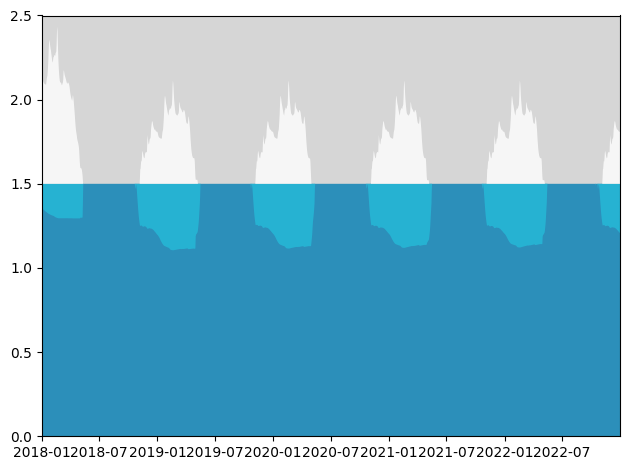

In [44]:
fig, ax = plt.subplots()

ax.fill_between(layers_v2['Date'], 0, layers_v2['water layer thickness, m'],  
                facecolor ='#027eb3', alpha = 0.8)
ax.fill_between(layers_v2['Date'], layers_v2['water layer thickness, m']-layers_v2['ice layer thickness,   m'], layers_v2['water layer thickness, m'],  
                facecolor ='#25bbd9', alpha = 0.8)
ax.fill_between(layers_v2['Date'], layers_v2['water layer thickness, m'], layers_v2['snow layer thickness,  m'] + layers_v2['water layer thickness, m'],  
                facecolor ='white', alpha = 0.8)

ax.set_facecolor('#d6d6d6')
plt.ylim(0,2.5)
plt.xlim(pd.to_datetime('2018-01-01'),pd.to_datetime('2022-12-31'))
fig.tight_layout()

(array([19144., 19158., 19174., 19188., 19205., 19219., 19236., 19250.,
        19266.]),
 [Text(19144.0, 0, '2022-06-01'),
  Text(19158.0, 0, '2022-06-15'),
  Text(19174.0, 0, '2022-07-01'),
  Text(19188.0, 0, '2022-07-15'),
  Text(19205.0, 0, '2022-08-01'),
  Text(19219.0, 0, '2022-08-15'),
  Text(19236.0, 0, '2022-09-01'),
  Text(19250.0, 0, '2022-09-15'),
  Text(19266.0, 0, '2022-10-01')])

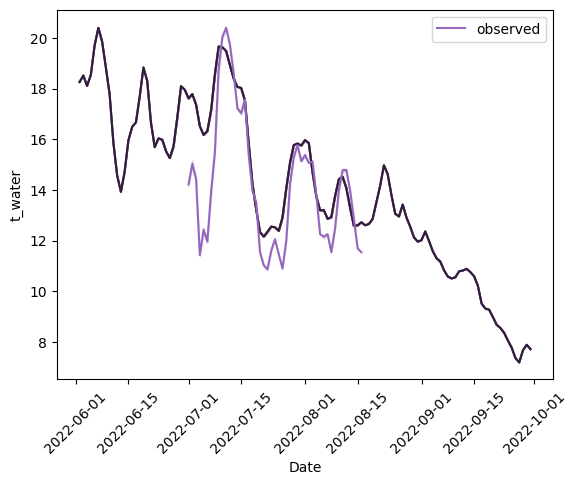

In [219]:
sns.lineplot(data= burned_vars_df[(burned_vars_df['t_water']!=-999)& (burned_vars_df['depth']==-1)], x='Date', y='t_water', hue = 'run_name', legend=False)
sns.lineplot(data=burned_vars_df, x='Date', y='WaterTemp_meas_degC', label='observed')
plt.xticks(rotation=45)

In [71]:
def get_performance(df, model_var, obs_var):
    runs = []
    var_mae = []
    df.loc[df[obs_var]==-999, obs_var] = np.nan
    for run in burned_vars_df['run_name'].unique():
        runs.append(run)
        var_mae.append(mean_absolute_error(df.loc[(df['run_name']==run) & (~df[obs_var].isna()), obs_var], df.loc[(df['run_name']==run) & (~df[obs_var].isna()),model_var]))
    
    df_performance = pd.DataFrame({'run_name': runs, f'{model_var}_mae': var_mae})

    return df_performance


In [72]:
#burned_vars_df = burned_vars_df.loc[burned_vars_df['depth']==-1.0]

df_co2_comp = get_performance(burned_vars_df, 'co2_water', 'CO2_mol_m3')
co2_top_10 = df_co2_comp.sort_values(by='co2_water_mae')[:10]
co2_top = df_co2_comp.sort_values(by='co2_water_mae')[:1]

In [73]:
co2_top_10

,run_name,co2_water_mae
13,14,120.742588
23,24,121.413507
76,77,122.235201
49,50,124.387297
11,12,124.652045
85,86,138.837175
16,17,141.473795
39,40,146.735469
88,89,147.645150
27,28,153.063328


In [74]:
df_ch4_comp = get_performance(burned_vars_df, 'ch4_water', 'CH4_mol_m3')
ch4_top_10 = df_ch4_comp.sort_values(by='ch4_water_mae')[:10]
ch4_top = df_ch4_comp.sort_values(by='ch4_water_mae')[:1]

In [75]:
df_ch4_comp

,run_name,ch4_water_mae
0,0,95.608002
1,1,95.306360
2,2,95.570625
3,3,95.553723
4,5,95.217749
...,...,...
94,95,95.617666
95,96,95.513738
96,97,95.566461
97,98,95.626139


In [76]:
df_o2_comp = get_performance(burned_vars_df, 'o2_water', 'DO_mol_m3')
o2_top_10 = df_o2_comp.sort_values(by='o2_water_mae')[:10]
o2_top = df_o2_comp.sort_values(by='o2_water_mae')[:1]

Text(0, 0.5, 'CO2 (umol/L)')

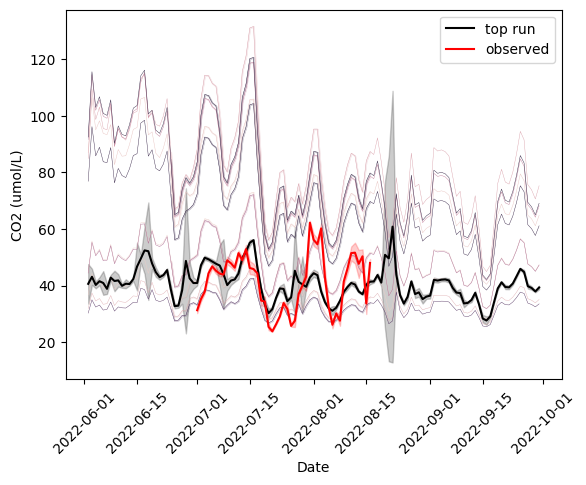

In [85]:
sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 ) & (burned_vars_df['depth']==-.75) & burned_vars_df['run_name'].isin(co2_top_10['run_name'])], x='Date', y='co2_water', hue = 'run_name', legend=False, linewidth=0.3)
sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 )  & burned_vars_df['run_name'].isin(co2_top['run_name'])], x='Date', y='co2_water', label='top run', color='black', errorbar='sd')
sns.lineplot(data= burned_co2_obs, x='Date', y='CO2_mol_m3', label='observed', color='red')
plt.xticks(rotation=45)
#plt.ylim(0,0.0001)
plt.ylabel('CO2 (umol/L)')

In [81]:
 burned_vars_df[(burned_vars_df['co2_water']!=-999 )  & burned_vars_df['run_name'].isin(co2_top['run_name'])]

,year,month,day,hour,integration_time,depth,t_water,Date,co2_water,ch4_water,...,dD (VSMOW),a250,A254,a350,a375,S_275_295,S_R,SUVA,CH4_mol_m3,DO_mol_m3
235690,2022,6,2,12.0,1613.0,-0.00,17.070093,2022-06-02,34.509233,0.040987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235691,2022,6,2,12.0,1613.0,-0.25,17.852093,2022-06-02,36.580572,0.063399,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235692,2022,6,2,12.0,1613.0,-0.50,17.855372,2022-06-02,36.641279,0.063765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235693,2022,6,2,12.0,1613.0,-0.75,17.858187,2022-06-02,36.687711,0.064085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235694,2022,6,2,12.0,1613.0,-1.00,18.259130,2022-06-02,49.531690,0.011929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253814,2022,9,30,12.0,1733.0,-0.25,7.659463,2022-09-30,39.095599,0.038673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253815,2022,9,30,12.0,1733.0,-0.50,7.704462,2022-09-30,39.548953,0.036716,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253816,2022,9,30,12.0,1733.0,-0.75,7.705897,2022-09-30,39.570278,0.036468,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
253817,2022,9,30,12.0,1733.0,-1.00,7.709503,2022-09-30,39.684320,0.034313,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
#sns.lineplot(data= burned_vars_df[(burned_vars_df['doc_water']!=-999) & (burned_vars_df['depth']==-1)], x='Date', y='doc_water', hue = 'run_name', legend=False, linewidth=0.3)
#sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='Date', y='TOC (mg/L)', label='observed', color='red')
#plt.xticks(rotation=45)


Text(0, 0.5, 'CH4 (umol/L)')

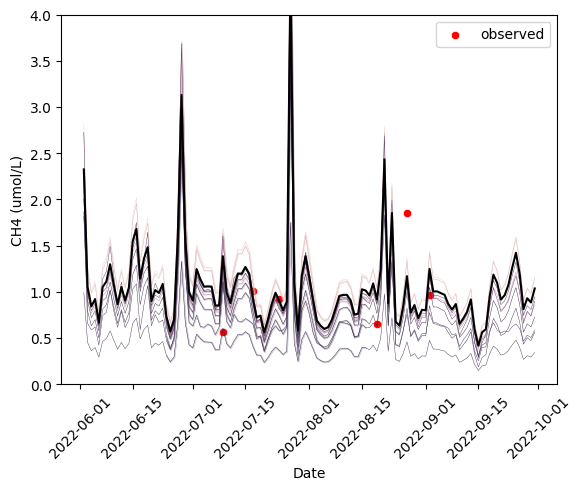

In [70]:
#sns.lineplot(data= burned_vars_df[(burned_vars_df['ch4_water']!=-999)  & (burned_vars_df['depth']==-1)], x='Date', y='ch4_water', hue = 'run_name', legend=False,linewidth=0.3)
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='Date', y='CH4_mol_m3', label='observed', color='red')
sns.lineplot(data= burned_vars_df[(burned_vars_df['ch4_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(ch4_top_10['run_name'])], x='Date', y='ch4_water', hue = 'run_name', legend=False, linewidth=0.3)
sns.lineplot(data= burned_vars_df[(burned_vars_df['ch4_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(ch4_top['run_name'])], x='Date', y='ch4_water', label='top run', color='black', legend=False)
plt.ylim(0,4)
plt.xticks(rotation=45)
plt.ylabel('CH4 (umol/L)')

(array([19158., 19174., 19188., 19205., 19219., 19236., 19250., 19266.]),
 [Text(19158.0, 0, '2022-06-15'),
  Text(19174.0, 0, '2022-07-01'),
  Text(19188.0, 0, '2022-07-15'),
  Text(19205.0, 0, '2022-08-01'),
  Text(19219.0, 0, '2022-08-15'),
  Text(19236.0, 0, '2022-09-01'),
  Text(19250.0, 0, '2022-09-15'),
  Text(19266.0, 0, '2022-10-01')])

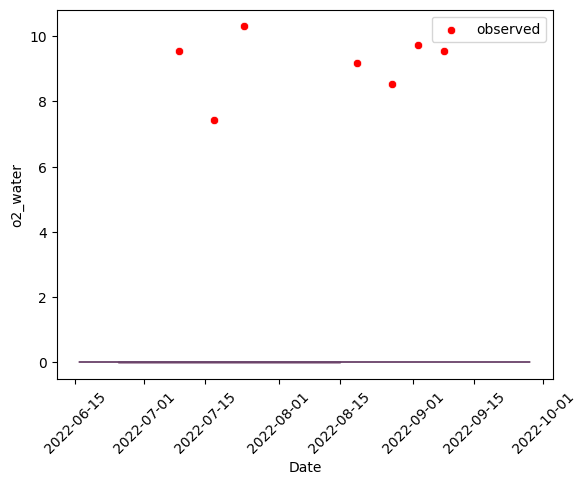

In [62]:
sns.lineplot(data= burned_vars_df[(burned_vars_df['ch4_water']!=-999 ) & (burned_vars_df['depth']==-1.5) & burned_vars_df['run_name'].isin(o2_top_10['run_name'])], x='Date', y='o2_water', hue = 'run_name', legend=False, linewidth=0.3)
#sns.lineplot(data= burned_vars_df[(burned_vars_df['co2_water']!=-999 ) & (burned_vars_df['depth']==-1) & burned_vars_df['run_name'].isin(o2_top['run_name'])], x='Date', y='o2_water', label='top run', color='black')
#sns.lineplot(data= burned_vars_df[(burned_vars_df['o2_water']!=-999)  & (burned_vars_df['depth']==-1)], x='Date', y='o2_water', hue = 'run_name', legend=False, linewidth=0.3)
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='Date', y='DO_mg_L', label='observed', color='red')
plt.xticks(rotation=45)
#plt.ylim(0,10)

<Axes: xlabel='Date', ylabel='pH'>

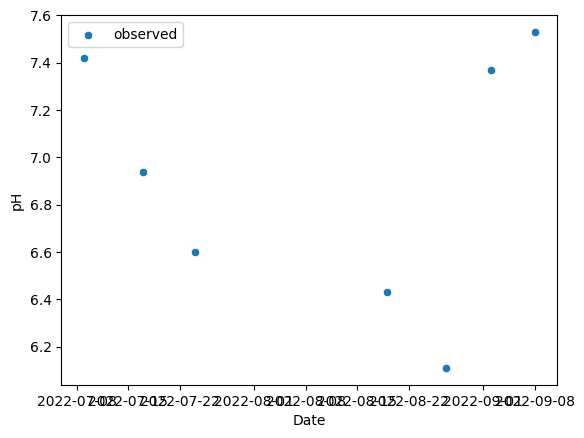

In [35]:
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='15B_FP'], x='Date', y='pH', label='observed')

In [66]:
burned_vars_df = burned_vars_df.replace(-999, np.nan)
run_summary = burned_vars_df[['run_name', 't_water', 'co2_water', 'ch4_water', 'o2_water', 'doc_water']].groupby(by='run_name').mean().reset_index()
sensitivity_df = pd.merge(run_summary, sample_matrix, on='run_name')

In [67]:
co2_top_10['run_name'] = co2_top_10['run_name']
ch4_top_10['run_name'] = ch4_top_10['run_name']
o2_top_10['run_name'] = o2_top_10['run_name']

In [68]:
sensitivity_df

,run_name,t_water,co2_water,ch4_water,o2_water,doc_water,kc0,mubeta0,VmaxCH4aeroboxid,khsCH4,khsO2,r0methprod
0,0,15.296307,372.204925,0.024017,0.079896,1.463398e+04,1.158432e-06,0.006893,5.645868e-09,0.047453,0.023897,8.111534e-10
1,1,15.296307,355.217561,0.500285,0.367400,9.739661e+02,2.968215e-08,0.000256,1.241052e-06,0.001685,0.002777,7.981896e-08
2,2,15.296307,250.058044,0.098546,2.338107,8.180333e-08,1.096452e-06,0.000041,2.182956e-06,0.005262,0.001395,1.951221e-07
3,3,15.296307,187.425131,0.142245,4.477216,2.315619e-17,1.031252e-05,0.000017,4.754556e-07,0.000773,0.306721,3.697769e-07
4,5,15.296307,360.148465,1.138648,0.301086,1.573531e+03,4.104659e-05,0.000375,7.962345e-07,0.030538,0.005895,2.700650e-07
...,...,...,...,...,...,...,...,...,...,...,...,...
94,95,15.296307,352.878815,0.013544,0.393068,7.682464e+02,1.060750e-06,0.000212,1.370856e-09,0.036995,0.045086,3.301476e-10
95,96,15.296307,140.703263,0.108810,6.148430,3.196225e-17,4.062955e-08,0.000012,9.747482e-07,0.033683,0.016274,8.012202e-08
96,97,15.296307,107.514389,0.165491,7.360261,6.421979e-17,4.721269e-06,0.000006,1.711268e-08,0.021265,0.053838,2.183494e-07
97,98,15.296307,122.701316,0.002359,6.802372,4.533419e-17,6.785576e-07,0.000010,2.524604e-07,0.021958,0.002496,4.920365e-10


/home/amullen/anaconda3/envs/lake_modeling/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


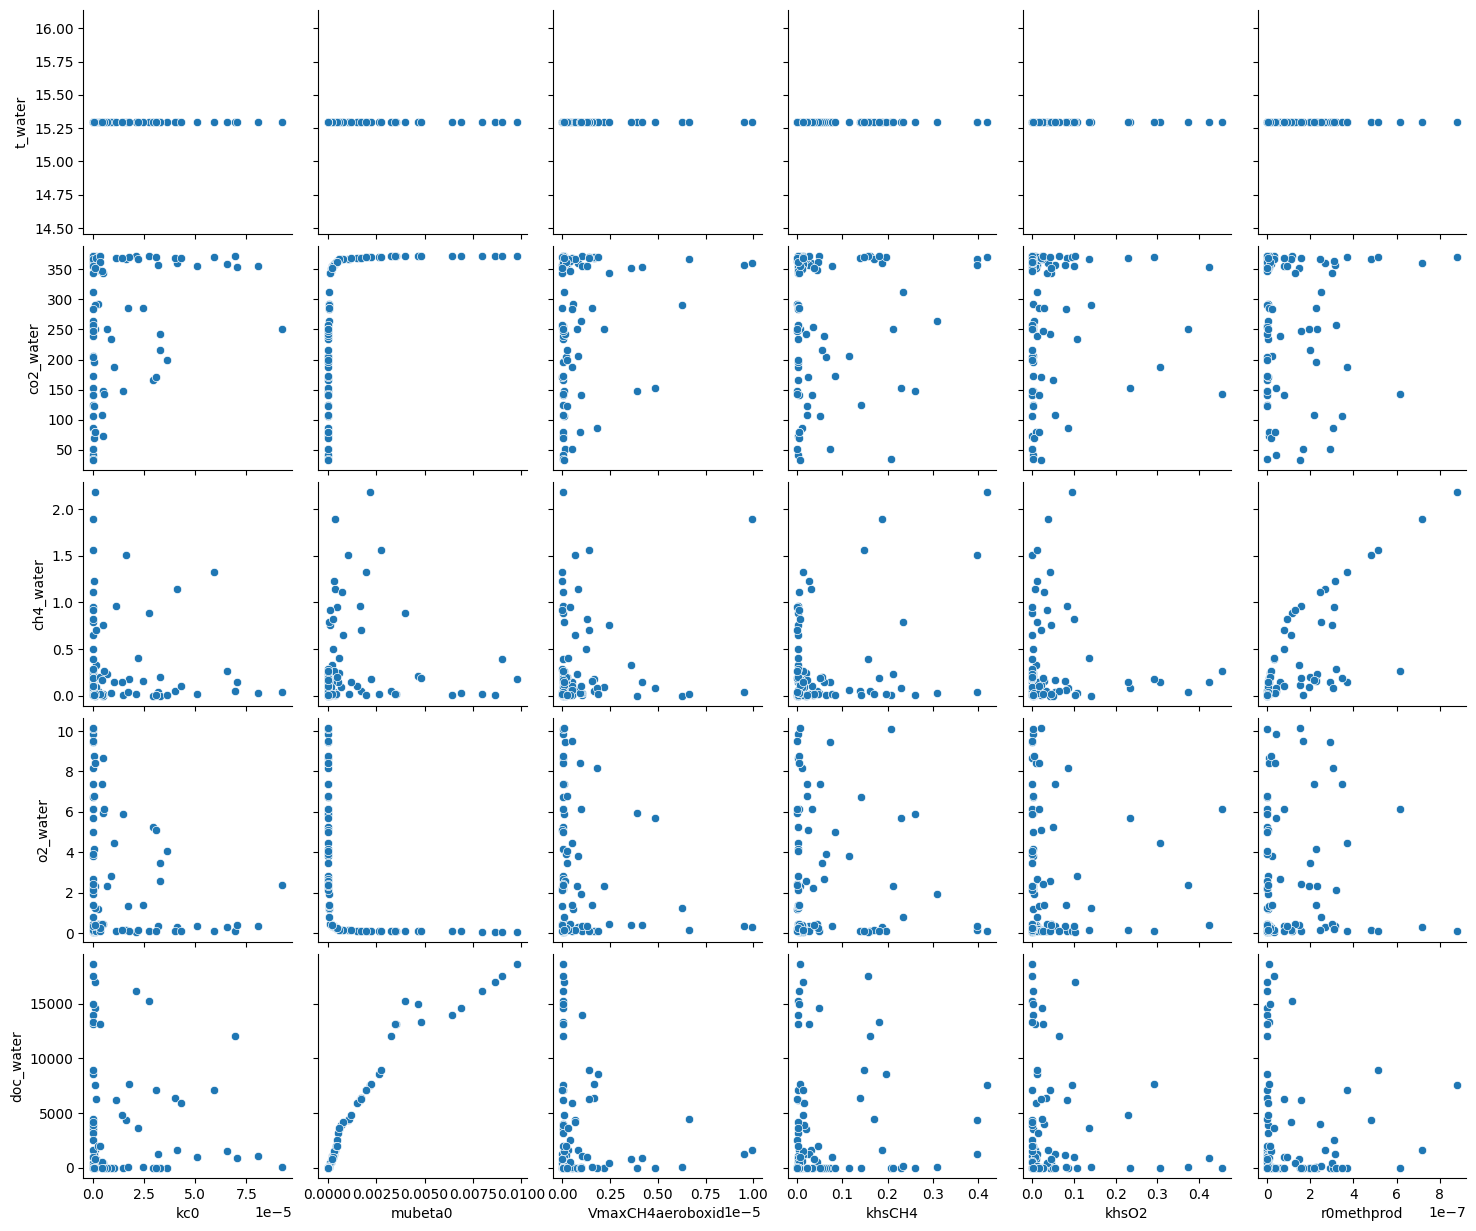

In [69]:
sns.pairplot(sensitivity_df, x_vars=['kc0', 'mubeta0', 'VmaxCH4aeroboxid', 'khsCH4', 'khsO2',
       'r0methprod'], y_vars=['t_water', 'co2_water', 'ch4_water', 'o2_water',
       'doc_water'])

In [31]:
sensitivity_df.loc[sensitivity_df['run_name'].isin(co2_top_10['run_name'])].min()

run_name            1.200000e+01
t_water             1.529700e+01
co2_water           2.155814e+01
ch4_water           6.238365e-03
o2_water            1.046237e+01
doc_water           1.130063e-02
kc0                 1.082433e-08
mubeta0             1.257814e-06
VmaxCH4aeroboxid    3.137953e-09
khsCH4              1.923591e-04
khsO2               2.736475e-04
r0methprod          1.812952e-09
dtype: float64

In [32]:
sensitivity_df.loc[sensitivity_df['run_name'].isin(co2_top_10['run_name'])].max()

run_name            8.900000e+01
t_water             1.529700e+01
co2_water           2.276685e+01
ch4_water           4.566740e-01
o2_water            1.059646e+01
doc_water           1.317694e-01
kc0                 4.862711e-06
mubeta0             5.741683e-06
VmaxCH4aeroboxid    1.796322e-06
khsCH4              2.068792e-01
khsO2               8.656436e-02
r0methprod          3.032381e-07
dtype: float64

In [33]:
sensitivity_df.loc[sensitivity_df['run_name'].isin(ch4_top_10['run_name'])].min()

run_name            7.000000e+00
t_water             1.529700e+01
co2_water           2.537777e+01
ch4_water           9.665965e-06
o2_water            4.193408e+00
doc_water           6.904199e-01
kc0                 2.220780e-08
mubeta0             7.923887e-06
VmaxCH4aeroboxid    3.951817e-08
khsCH4              1.946104e-04
khsO2               1.152690e-04
r0methprod          1.221800e-10
dtype: float64

In [34]:
sensitivity_df.loc[sensitivity_df['run_name'].isin(ch4_top_10['run_name'])].max()

run_name            7.600000e+01
t_water             1.529700e+01
co2_water           1.862322e+03
ch4_water           8.629275e-04
o2_water            1.025179e+01
doc_water           1.301085e+03
kc0                 8.062711e-05
mubeta0             6.423345e-03
VmaxCH4aeroboxid    6.266080e-06
khsCH4              4.142895e-03
khsO2               4.235942e-01
r0methprod          7.793751e-09
dtype: float64

In [35]:
sensitivity_df.loc[sensitivity_df['run_name'].isin(o2_top_10['run_name'])].min()

run_name            0.000000e+00
t_water             1.529700e+01
co2_water           1.025638e+03
ch4_water           2.338260e-04
o2_water            1.918107e+00
doc_water           8.707424e+02
kc0                 1.988344e-08
mubeta0             3.507573e-03
VmaxCH4aeroboxid    2.342817e-09
khsCH4              1.166479e-03
khsO2               1.721847e-04
r0methprod          1.096336e-10
dtype: float64

In [36]:
sensitivity_df.loc[sensitivity_df['run_name'].isin(o2_top_10['run_name'])].max()

run_name            7.800000e+01
t_water             1.529700e+01
co2_water           4.243186e+03
ch4_water           1.822237e-01
o2_water            7.927421e+00
doc_water           1.840875e+03
kc0                 2.753691e-05
mubeta0             9.782961e-03
VmaxCH4aeroboxid    1.001244e-06
khsCH4              1.806968e-01
khsO2               1.019062e-01
r0methprod          1.136508e-07
dtype: float64

### Unburned Plots

In [ ]:
sns.lineplot(data= unburned_vars_df[unburned_vars_df['t_water']!=-999], x='datetime', y='t_water', hue = 'run_name')
sns.lineplot(data=unburned_co2_obs, x='Date', y='WaterTemp_degC', label='observed')

In [ ]:
sns.lineplot(data= unburned_vars_df[unburned_vars_df['co2_water']!=-999], x='datetime', y='co2_water', hue = 'run_name')
sns.lineplot(data=unburned_co2_obs, x='Date', y='CO2_High_ppm', label='observed')
plt.ylim(0,8000)

In [ ]:
np.nanmean(unburned_co2_obs['CO2_High_ppm'])

In [ ]:
sns.lineplot(data= unburned_vars_df[unburned_vars_df['ch4_water']!=-999], x='datetime', y='ch4_water', hue = 'run_name')
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='UB_FP'], x='date', y='CH4_ppm', label='observed')
plt.ylim(0,100)

In [ ]:
np.nanmean(ch4_obs.loc[ch4_obs['sample']=='UB_FP', 'CH4_ppm'])

In [ ]:
sns.scatterplot(data=ch4_obs[ch4_obs['sample']=='UB_FP'], x='date', y='pH', label='observed')